# Import data

In [2]:
import osmnx as ox
import geopandas as gpd


# 1. Load your cleaned deliveries dataset (GeoPackage or CSV with geometry)
deliveries = gpd.read_file(
    "../data/deliveries_utm44.gpkg",
    layer="deliveries_utm44",
    engine="pyogrio",
    use_arrow=True
    )

# 2. Load the OSMnx city boundary
hyd_admin = ox.geocode_to_gdf("Hyderabad, Telangana, India")

# 3. (Optional) Load road network
roads = gpd.read_file(
    "../data/hyd_roads.gpkg",
    engine="pyogrio",
    use_arrow=True
    )

# 4. Project everything to EPSG:3857 for clustering (meters)
deliveries = deliveries.to_crs(epsg=3857)
hyd_admin = hyd_admin.to_crs(epsg=3857)
roads = roads.to_crs(epsg=3857)


In [3]:
# If hyd_admin is a single-row GeoDataFrame, get the polygon
city_polygon = hyd_admin.union_all()

# Filter deliveries to only those within the city boundary
deliveries_in_city = deliveries[deliveries.within(city_polygon)].copy()
print(f"Deliveries inside Hyderabad urban area: {len(deliveries_in_city)}")
print(f"Deliveries outside (outliers): {len(deliveries) - len(deliveries_in_city)}")


Deliveries inside Hyderabad urban area: 605
Deliveries outside (outliers): 33


# Clustering (basic)

In [4]:
import numpy as np

# Extract projected coordinates (meters) from geometry
coords = np.array([(point.x, point.y) for point in deliveries_in_city.geometry])
print(coords.shape)  # Should be (n_points, 2)


(605, 2)


In [5]:
!uv add scikit-learn

Resolved 130 packages in 1ms
Audited 126 packages in 0.10ms


In [6]:
from sklearn.cluster import KMeans

K = 5  # Choose your desired number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=K, random_state=42)
deliveries_in_city['cluster_kmeans'] = kmeans.fit_predict(coords)
# Make sure clusters start from 1 for labeling
deliveries_in_city['cluster_name'] = deliveries_in_city['cluster_kmeans'].apply(lambda x: f'C{x+1}')


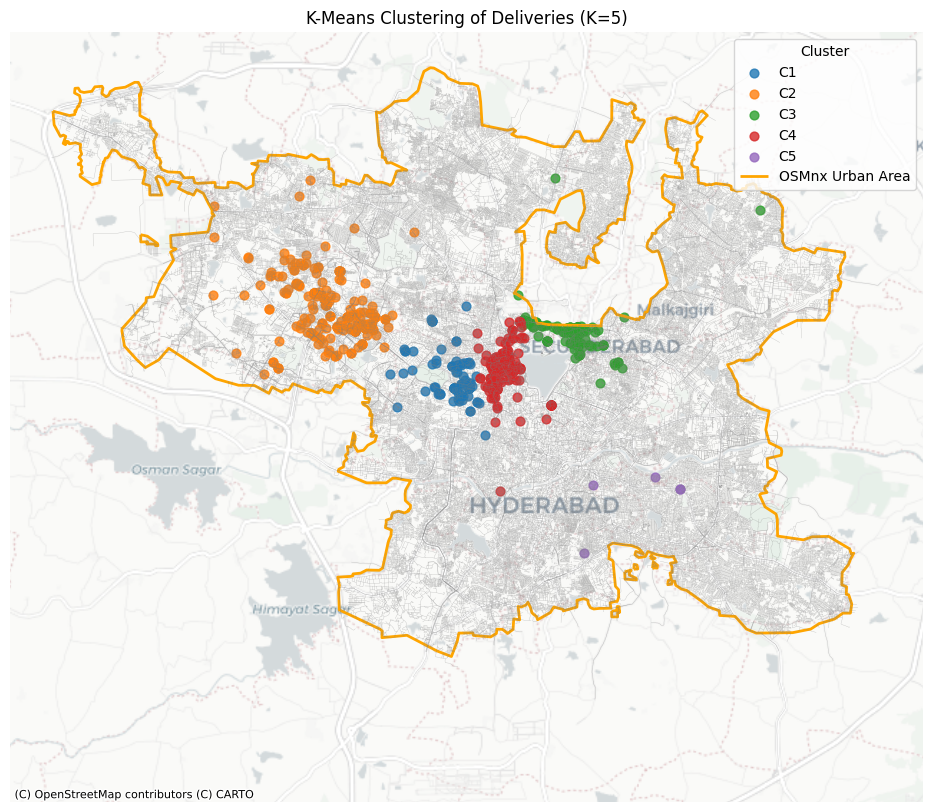

In [7]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(12, 10))
# Plot points by cluster, get color map
cmap = plt.get_cmap('tab10')
unique_clusters = sorted(deliveries_in_city['cluster_kmeans'].unique())
for idx, cl in enumerate(unique_clusters):
    subset = deliveries_in_city[deliveries_in_city['cluster_kmeans'] == cl]
    subset.plot(
        ax=ax,
        color=cmap(idx),
        markersize=40,
        alpha=0.8,
        label=f'C{cl+1}'
    )

# Overlay boundary and roads
hyd_admin.boundary.plot(ax=ax, color='orange', linewidth=2, label='OSMnx Urban Area')
roads.plot(ax=ax, linewidth=0.3, color='gray', alpha=0.4)

# Basemap and styling
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.legend(title='Cluster', loc='upper right')
plt.title(f"K-Means Clustering of Deliveries (K={K})")
plt.show()


# Benchmark Speeds

In [8]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# List of pincodes as strings for geocoding
pincodes = ['500084', '500032', '500081', '500001', '500033', '560066']

# Initialize geocoder (user_agent is required for Nominatim)
geolocator = Nominatim(user_agent="rastaa")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Dictionary to hold coordinates
pincode_coords = {}

for pin in pincodes:
    # Query as "Pincode, India"
    location = geocode(f"{pin}, India")
    if location:
        pincode_coords[pin] = (location.longitude, location.latitude)
        print(f"{pin}: {location.latitude}, {location.longitude}")
    else:
        print(f"Failed to geocode {pin}")

print(pincode_coords)


500084: 17.4626345, 78.3596226
500032: 17.4410759, 78.3531802
500081: 17.4476921, 78.3830008
500001: 17.3993088, 78.4719341
500033: 17.4310775, 78.4057029
560066: 12.9668492, 77.7516428
{'500084': (78.3596226, 17.4626345), '500032': (78.3531802, 17.4410759), '500081': (78.3830008, 17.4476921), '500001': (78.4719341, 17.3993088), '500033': (78.4057029, 17.4310775), '560066': (77.7516428, 12.9668492)}


In [9]:
import numpy as np

# Project to 3857 for Euclidean (if needed)
deliveries_euclid = deliveries_in_city.to_crs(epsg=3857)
coords_euclid = np.array([(p.x, p.y) for p in deliveries_euclid.geometry])

# Project centroids
from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3857, always_xy=True)
centroids_euclid = {pin: transformer.transform(lon, lat) for pin, (lon, lat) in pincode_coords.items()}


In [10]:
deliveries_geo = deliveries_in_city.to_crs(epsg=4326)
coords_lonlat = np.array([(p.x, p.y) for p in deliveries_geo.geometry])
centroids_lonlat = {pin: (lon, lat) for pin, (lon, lat) in pincode_coords.items()}


In [11]:
import time
from geopy.distance import geodesic

# --- Euclidean ---
start = time.time()
assigned_euclid = []
for pt in coords_euclid:
    dists = {pin: np.linalg.norm(np.subtract(pt, xy)) for pin, xy in centroids_euclid.items()}
    assigned_euclid.append(min(dists, key=dists.get))
print(f"Euclidean done in {time.time() - start:.2f} seconds.")

# --- Haversine ---
def haversine_np(lon1, lat1, lon2, lat2):
    R = 6_371_000  # meters
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

start = time.time()
assigned_hav = []
for lon1, lat1 in coords_lonlat:
    dists = {pin: haversine_np(lon1, lat1, lon2, lat2) 
             for pin, (lon2, lat2) in centroids_lonlat.items()}
    assigned_hav.append(min(dists, key=dists.get))
print(f"Haversine done in {time.time() - start:.2f} seconds.")

# --- Geodesic ---
start = time.time()
assigned_geo = []
for lon1, lat1 in coords_lonlat:
    dists = {pin: geodesic((lat1, lon1), (lat2, lon2)).meters
             for pin, (lon2, lat2) in centroids_lonlat.items()}
    assigned_geo.append(min(dists, key=dists.get))
print(f"Geodesic done in {time.time() - start:.2f} seconds.")


Euclidean done in 0.01 seconds.
Haversine done in 0.03 seconds.
Geodesic done in 0.64 seconds.


# Voronoi Partitioning (Fixed Centroids)

In [12]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# List of pincodes as strings for geocoding
pincodes = ['500084', '500032', '500081', '500001', '500033']

# '560066' skipped as it is in Bengaluru, not Hyderabad

# Initialize geocoder (user_agent is required for Nominatim)
geolocator = Nominatim(user_agent="rastaa")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Dictionary to hold coordinates
pincode_coords = {}

for pin in pincodes:
    # Query as "Pincode, India"
    location = geocode(f"{pin}, India")
    if location:
        pincode_coords[pin] = (location.longitude, location.latitude)
        print(f"{pin}: {location.latitude}, {location.longitude}")
    else:
        print(f"Failed to geocode {pin}")

print(pincode_coords)


500084: 17.4626345, 78.3596226
500032: 17.4410759, 78.3531802
500081: 17.4476921, 78.3830008
500001: 17.3993088, 78.4719341
500033: 17.4310775, 78.4057029
{'500084': (78.3596226, 17.4626345), '500032': (78.3531802, 17.4410759), '500081': (78.3830008, 17.4476921), '500001': (78.4719341, 17.3993088), '500033': (78.4057029, 17.4310775)}


In [13]:
for pin in pincodes:
    location = geocode(f"{pin}, India")
    print(pin, "->", location)
    if location:
        print("lat/lon:", location.latitude, location.longitude)


500084 -> 500084, Ward 104 Kondapur, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Ranga Reddy, Telangana, India
lat/lon: 17.4626345 78.3596226
500032 -> 500032, Ward 105 Gachibowli, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Ranga Reddy, Telangana, India
lat/lon: 17.4410759 78.3531802
500081 -> 500081, Ward 104 Kondapur, Greater Hyderabad Municipal Corporation West Zone, Hyderabad, Serilingampalle mandal, Ranga Reddy, Telangana, India
lat/lon: 17.4476921 78.3830008
500001 -> 500001, Ward 78 Gunfoundry, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Nampally mandal, Hyderabad, Telangana, India
lat/lon: 17.3993088 78.4719341
500033 -> 500033, Ward 95 Jubilee Hills, Greater Hyderabad Municipal Corporation Central Zone, Hyderabad, Shaikpet mandal, Hyderabad, Telangana, India
lat/lon: 17.4310775 78.4057029


In [14]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Build DataFrame
centroids_df = pd.DataFrame([
    {'pincode': pin, 'lon': lon, 'lat': lat}
    for pin, (lon, lat) in pincode_coords.items()
])

print(centroids_df)  # Check for correct values

# Build GeoDataFrame (lon, lat order!)
centroid_gdf = gpd.GeoDataFrame(
    centroids_df,
    geometry=[Point(lon, lat) for lon, lat in zip(centroids_df['lon'], centroids_df['lat'])],
    crs='EPSG:4326'
)


  pincode        lon        lat
0  500084  78.359623  17.462635
1  500032  78.353180  17.441076
2  500081  78.383001  17.447692
3  500001  78.471934  17.399309
4  500033  78.405703  17.431078


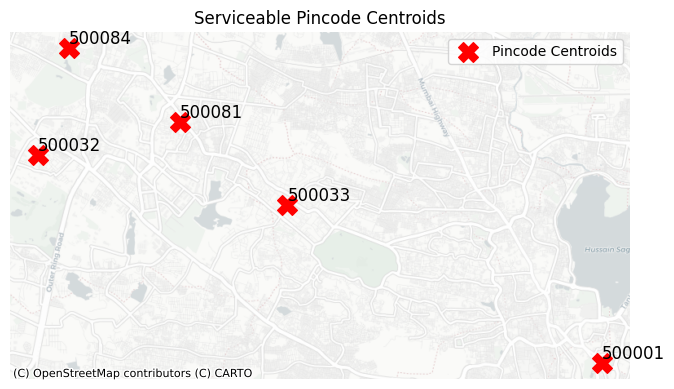

In [15]:
import matplotlib.pyplot as plt
import contextily as ctx

# Project to Web Mercator for contextily
centroid_gdf_web = centroid_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 8))
centroid_gdf_web.plot(ax=ax, color='red', marker='X', markersize=200, label='Pincode Centroids')

# Add labels for each point
for x, y, label in zip(centroid_gdf_web.geometry.x, centroid_gdf_web.geometry.y, centroid_gdf_web['pincode']):
    ax.text(x, y, label, fontsize=12, ha='left', va='bottom', color='black')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.legend()
plt.title('Serviceable Pincode Centroids')
plt.show()


In [16]:
# Assume deliveries_in_city is already a GeoDataFrame in EPSG:4326
if deliveries_in_city.crs.to_epsg() != 4326:
    deliveries_in_city = deliveries_in_city.to_crs(epsg=4326)
    
deliv_coords = np.array([(pt.x, pt.y) for pt in deliveries_in_city.geometry])


In [17]:
centroids_df = centroid_gdf[['pincode', 'lon', 'lat']]  # ensure columns are in correct order
centroid_coords = centroids_df[['lon', 'lat']].to_numpy()


In [18]:
def haversine_matrix(deliv_lonlat, centroid_lonlat):
    # Inputs: (N,2), (K,2)
    R = 6371  # Earth radius in km
    lon1, lat1 = np.radians(deliv_lonlat[:, 0]), np.radians(deliv_lonlat[:, 1])
    lon2, lat2 = np.radians(centroid_lonlat[:, 0]), np.radians(centroid_lonlat[:, 1])
    # Broadcasting to all pairs
    dlon = lon1[:, None] - lon2[None, :]
    dlat = lat1[:, None] - lat2[None, :]
    a = np.sin(dlat/2)**2 + np.cos(lat1)[:, None] * np.cos(lat2)[None, :] * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # (N, K)


In [19]:
dist_matrix = haversine_matrix(deliv_coords, centroid_coords)  # (N_deliv, N_centroids)
nearest_idx = np.argmin(dist_matrix, axis=1)
assigned_pincodes = centroids_df.iloc[nearest_idx]['pincode'].values
deliveries_in_city['assigned_pincode'] = assigned_pincodes


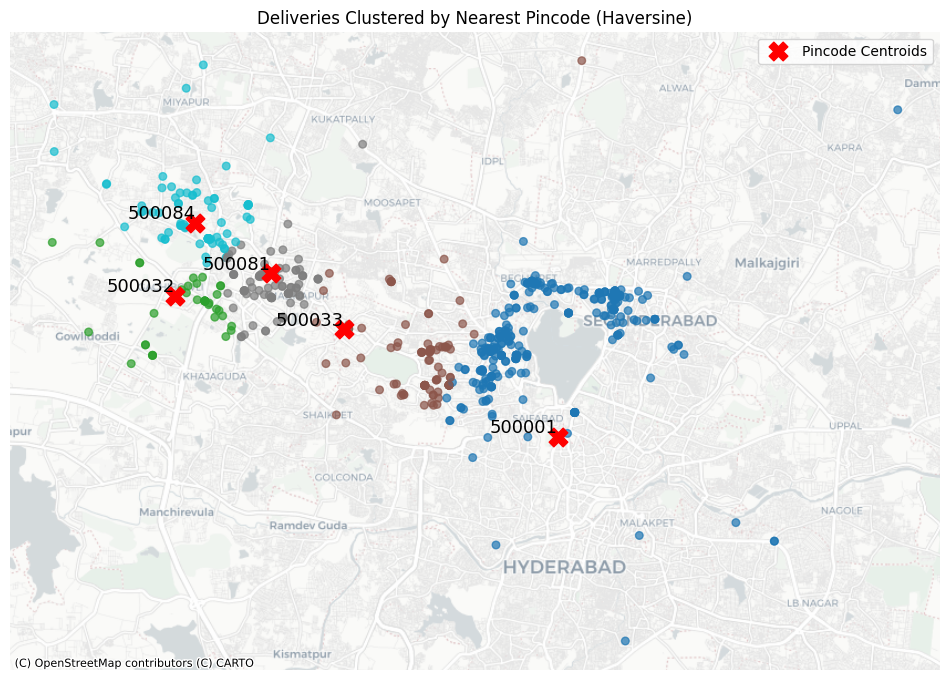

In [20]:
import matplotlib.pyplot as plt
import contextily as ctx

deliveries_in_city_web = deliveries_in_city.to_crs(epsg=3857)
centroid_gdf_web = centroid_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))
deliveries_in_city_web.plot(
    ax=ax, 
    column='assigned_pincode', 
    categorical=True, 
    legend=True, 
    markersize=30, 
    cmap='tab10', 
    alpha=0.7
)
centroid_gdf_web.plot(ax=ax, color='red', marker='X', markersize=180, label='Pincode Centroids')
for x, y, label in zip(centroid_gdf_web.geometry.x, centroid_gdf_web.geometry.y, centroid_gdf_web['pincode']):
    ax.text(x, y, label, fontsize=13, ha='right', va='bottom', color='black')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.legend()
plt.title('Deliveries Clustered by Nearest Pincode (Haversine)')
plt.show()


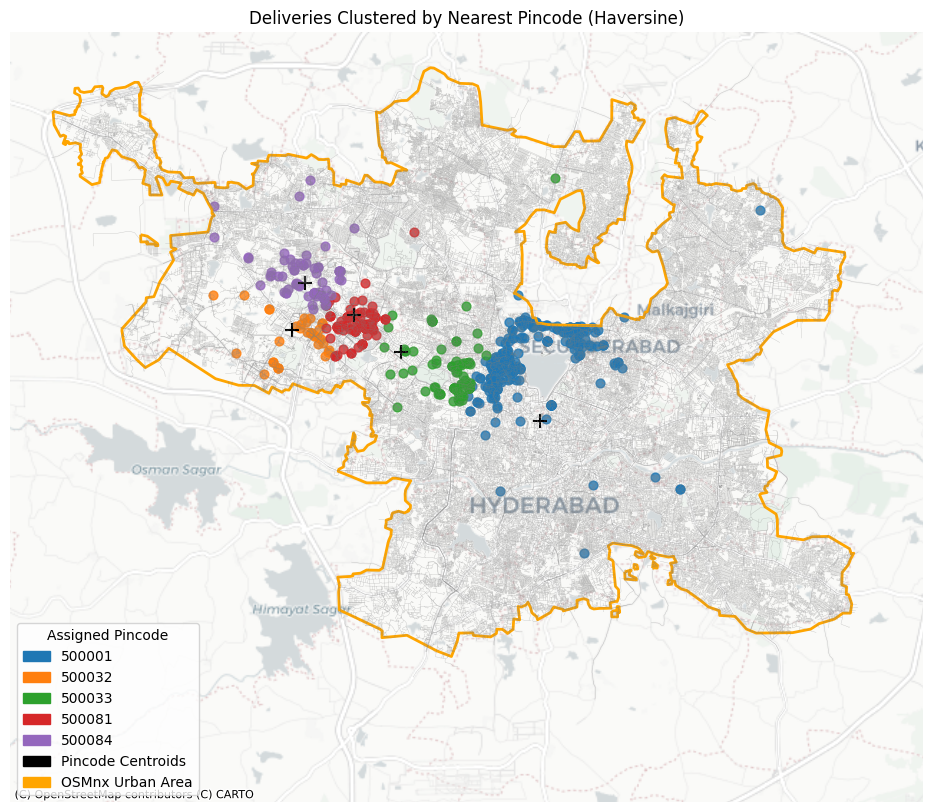

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx

# Get unique pincodes & assign colors
unique_pins = sorted(deliveries_in_city_web['assigned_pincode'].unique())
cmap = plt.get_cmap('tab10')
color_map = {pin: cmap(i) for i, pin in enumerate(unique_pins)}

# Plot deliveries by assigned pincode
fig, ax = plt.subplots(figsize=(12, 10))
for i, pin in enumerate(unique_pins):
    subset = deliveries_in_city_web[deliveries_in_city_web['assigned_pincode'] == pin]
    subset.plot(
        ax=ax,
        color=color_map[pin],
        markersize=40,
        alpha=0.8,
        label=f"Pincode {pin}"
    )

# Plot Hyderabad boundary and roads
hyd_admin.boundary.plot(ax=ax, color='orange', linewidth=2, label='OSMnx Urban Area')
roads.plot(ax=ax, linewidth=0.3, color='gray', alpha=0.4)

# Plot centroid X's
centroid_gdf_web.plot(ax=ax, color='black', marker='+', markersize=100, label='Pincode Centroids')
# for x, y, label in zip(centroid_gdf_web.geometry.x, centroid_gdf_web.geometry.y, centroid_gdf_web['pincode']):
#     ax.text(x, y, label, fontsize=13, ha='right', va='bottom', color='black')

# Basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Style
ax.set_axis_off()
# Custom legend for clusters (to avoid duplicate handles)
handles = [mpatches.Patch(color=color_map[pin], label=str(pin)) for pin in unique_pins]
handles.append(mpatches.Patch(color='black', label='Pincode Centroids'))
handles.append(mpatches.Patch(color='orange', label='OSMnx Urban Area'))
plt.legend(handles=handles, title='Assigned Pincode', loc='lower left')
plt.title('Deliveries Clustered by Nearest Pincode (Haversine)')
plt.show()


In [22]:
print(deliveries_in_city_web['assigned_pincode'].value_counts())


assigned_pincode
500001    313
500033     91
500081     89
500084     75
500032     37
Name: count, dtype: int64


## Analysis

Limitation:

The cluster boundaries are entirely determined by the locations of the centroids, not the actual density or spread of the deliveries.


| Approach                                  | Pros                                        | Cons                           |
| ----------------------------------------- | ------------------------------------------- | ------------------------------ |
| Add more centroids (pincodes)             | Balances clusters, operationally simplest   | Needs business approval        |
| K-means or density-based clustering       | Perfectly fits demand, flexible             | May not match allowed pincodes |
| Demand-weighted cluster “centers”         | Better for routing, still respects clusters | Centroids ≠ actual pincodes    |
| Hybrid: use for routing but not reporting | Flexible, operationally helpful             | Adds complexity                |


# Demand-weighted Centroids

In [23]:
import geopandas as gpd

# Group by assigned_pincode and calculate the centroid of all points in each group
weighted_centroids = (
    deliveries_in_city_web
    .dissolve(by='assigned_pincode')
    .centroid
    .reset_index()
    .rename(columns={0: 'geometry'})
)
# Make it a GeoDataFrame with same CRS
weighted_centroids = gpd.GeoDataFrame(weighted_centroids, geometry='geometry', crs=deliveries_in_city_web.crs)


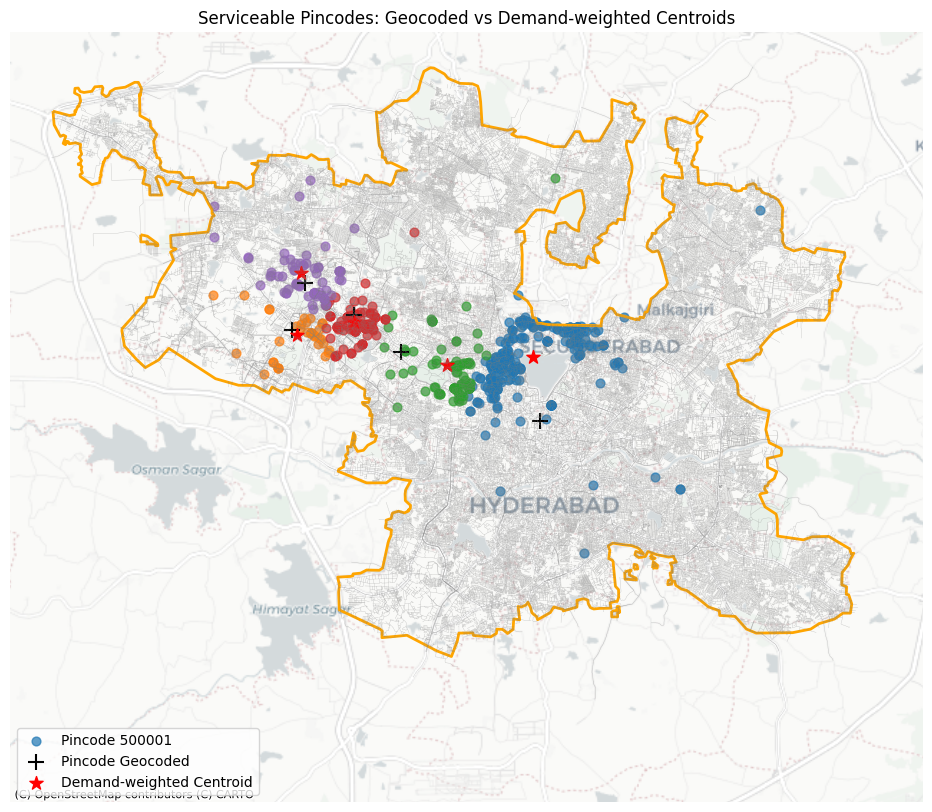

In [24]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(12, 10))

# Plot deliveries colored by assigned_pincode
for i, pin in enumerate(unique_pins):
    subset = deliveries_in_city_web[deliveries_in_city_web['assigned_pincode'] == pin]
    subset.plot(
        ax=ax,
        color=color_map[pin],
        markersize=40,
        alpha=0.7,
        label=f"Pincode {pin}" if i == 0 else None  # Avoid duplicate legend
    )

# Plot Hyderabad boundary and roads
hyd_admin.boundary.plot(ax=ax, color='orange', linewidth=2)
roads.plot(ax=ax, linewidth=0.3, color='gray', alpha=0.4)

# Plot geocoded centroids (the black +)
centroid_gdf_web.plot(ax=ax, color='black', marker='+', markersize=120, label='Pincode Geocoded')

# Plot demand-weighted centroids (red stars)
weighted_centroids.plot(ax=ax, color='red', marker='*', markersize=100, label='Demand-weighted Centroid')

# Optionally: label the demand-weighted centroid
# for idx, row in weighted_centroids.iterrows():
#     ax.text(row.geometry.x, row.geometry.y, str(row['assigned_pincode']), fontsize=14, color='red', weight='bold')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.legend(loc='lower left')
plt.title('Serviceable Pincodes: Geocoded vs Demand-weighted Centroids')
plt.show()


Deliveries were assigned to the nearest client-specified serviceable pincode using Haversine (great-circle) distance, in accordance with client operational requirements. Optionally, more efficient micro-hub locations can be proposed using demand-weighted cluster centroids based on delivery density.

# Network-based Clustering

Results:

Cluster assignment was performed using Haversine (great-circle) distance to ensure computational efficiency and robust performance at scale. Intra-cluster route optimization is then performed using the real road network for operational accuracy. Network-based clustering is possible but not generally recommended for large city-scale delivery systems due to the exponential computational cost.

E.g. 3m waiting time for 50/605 points.

In [ ]:
import osmnx as ox

# Ensure your admin polygon is in WGS84
if hyd_admin.crs is None or hyd_admin.crs.to_epsg() != 4326:
    hyd_admin = hyd_admin.to_crs(epsg=4326)

hyd_poly = hyd_admin.geometry.iloc[0]

# Now use OSMnx with this polygon
G = ox.graph_from_polygon(hyd_poly, network_type='drive')


In [29]:
!uv add tqdm

Resolved 131 packages in 2.31s
Installed 1 package in 100ms
 + tqdm==4.67.1


In [ ]:
# import numpy as np
# import pandas as pd
# from joblib import Parallel, delayed
# import networkx as nx
# from tqdm import tqdm

# # Sample 50 points for this demo
# sample = deliveries_in_city.sample(50, random_state=42).reset_index(drop=True)
# sample_coords = np.array([(geom.y, geom.x) for geom in sample.geometry])  # lat, lon
# sample_nearest_nodes = ox.nearest_nodes(G, X=sample_coords[:,1], Y=sample_coords[:,0])
# N = len(sample_nearest_nodes)

# def get_network_distance(i, j):
#     try:
#         return nx.shortest_path_length(G, sample_nearest_nodes[i], sample_nearest_nodes[j], weight='length')
#     except nx.NetworkXNoPath:
#         return np.inf

# # Generate all pairs (upper triangle)
# pairs = [(i, j) for i in range(N) for j in range(i+1, N)]

# # Compute distances in parallel
# results = Parallel(n_jobs=-1, prefer="threads", verbose=10)(
#     delayed(get_network_distance)(i, j) for i, j in tqdm(pairs)
# )

# # Fill distance matrix
# dist_matrix = np.zeros((N, N))
# for idx, (i, j) in enumerate(pairs):
#     dist_matrix[i, j] = dist_matrix[j, i] = results[idx]


# ### ! 3m 35.6s

  0%|          | 0/1225 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
  3%|▎         | 40/1225 [00:00<00:06, 194.45it/s][Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.0s
  6%|▌         | 74/1225 [00:08<02:54,  6.58it/s] [Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    8.1s
  9%|▉         | 116/1225 [00:19<09:32,  1.94it/s][Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.9s
 14%|█▎        | 168/1225 [00:32<07:56,  2.22it/s][Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   32

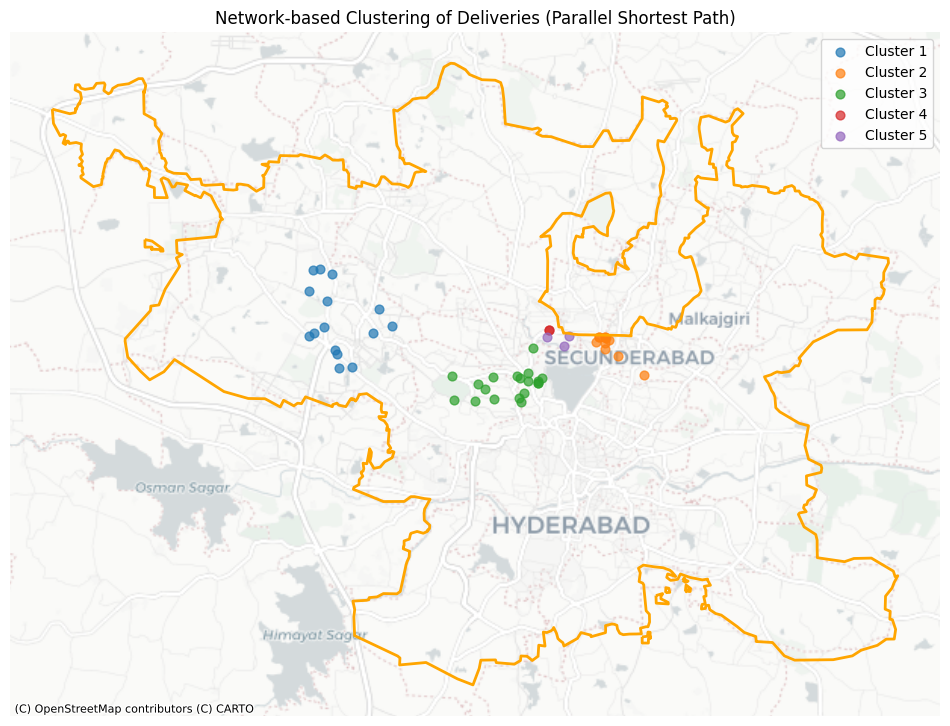

In [65]:
import contextily as ctx
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

n_clusters = 5  # set as needed
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
labels = clustering.fit_predict(dist_matrix)

sample['network_cluster'] = labels

sample_web = sample.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(12,10))
for cl in np.unique(labels):
    sample_web[sample_web['network_cluster'] == cl].plot(
        ax=ax, markersize=40, alpha=0.7, label=f"Cluster {cl+1}"
    )

hyd_admin_web = hyd_admin.to_crs(epsg=3857)
hyd_admin_web.boundary.plot(ax=ax, color='orange', linewidth=2)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.legend()
plt.title("Network-based Clustering of Deliveries (Parallel Shortest Path)")
plt.show()


In [ ]:
# import networkx as nx

# # 1. Find the largest strongly connected component (for directed) or connected component (for undirected)
# if nx.is_directed(G):
#     components = list(nx.strongly_connected_components(G))
# else:
#     components = list(nx.connected_components(G))

# largest_cc = max(components, key=len)
# # 2. Only keep deliveries whose nearest node is in this component
# delivery_nodes = ox.nearest_nodes(G, X=sample.geometry.x, Y=sample.geometry.y)
# in_largest_cc = np.array([node in largest_cc for node in delivery_nodes])

# # 3. Filter your sample to only those in largest CC
# sample_connected = sample[in_largest_cc].reset_index(drop=True)
# connected_nodes = delivery_nodes[in_largest_cc]
# N = len(sample_connected)

# # 4. Recompute the distance matrix for these nodes only
# def get_network_distance(i, j):
#     try:
#         return nx.shortest_path_length(G, connected_nodes[i], connected_nodes[j], weight='length')
#     except nx.NetworkXNoPath:
#         return np.inf

# pairs = [(i, j) for i in range(N) for j in range(i+1, N)]
# from joblib import Parallel, delayed
# results = Parallel(n_jobs=-1, prefer="threads")(
#     delayed(get_network_distance)(i, j) for i, j in pairs
# )

# dist_matrix_cc = np.zeros((N, N))
# for idx, (i, j) in enumerate(pairs):
#     dist_matrix_cc[i, j] = dist_matrix_cc[j, i] = results[idx]

# # Now, all points are truly mutually reachable (should be no inf)
# assert not np.isinf(dist_matrix_cc).any()

### ! 3m36s


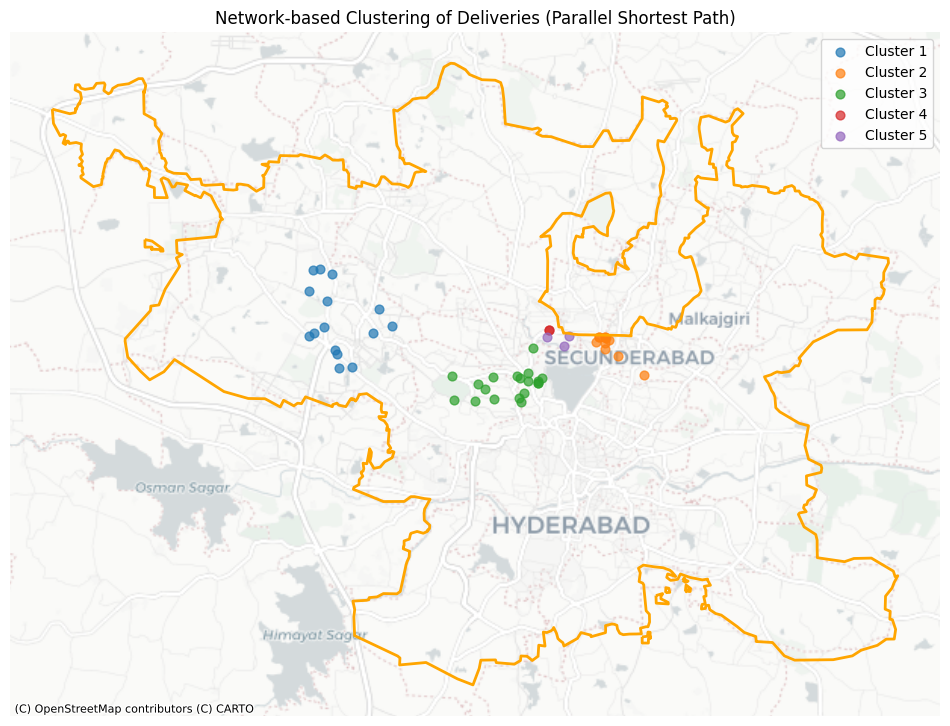

In [ ]:
# clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
# labels_cc = clustering.fit_predict(dist_matrix_cc)
# sample_connected['network_cluster'] = labels_cc

# sample_web = sample_connected.to_crs(epsg=3857)
# fig, ax = plt.subplots(figsize=(12,10))
# for cl in np.unique(labels):
#     sample_web[sample_web['network_cluster'] == cl].plot(
#         ax=ax, markersize=40, alpha=0.7, label=f"Cluster {cl+1}"
#     )

# hyd_admin_web = hyd_admin.to_crs(epsg=3857)
# hyd_admin_web.boundary.plot(ax=ax, color='orange', linewidth=2)
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
# ax.set_axis_off()
# plt.legend()
# plt.title("Network-based Clustering of Deliveries (Parallel Shortest Path)")
# plt.show()